### Setup & Imports

In [1]:
%pip install Pillow sentence-transformers torch milvus pandas imageio pymilvus onnxruntime ftfy openai-clip matplotlib

In [2]:
%run cliponnx/models.py
%run cliponnx/simple_tokenizer.py

In [3]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from PIL import Image
import torch
import glob
import regex as rg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from cliponnx.models import TextualModel, VisualModel
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score

from helpers import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(10)

In [5]:
ground_truth_de, ground_truth_en = create_ground_truth_dicts()
# print(ground_truth_de)
# print(ground_truth_en)

### Model 1: CLIP+Vision Transformers (ViT) model with multilingual training

In [6]:
img_model = SentenceTransformer('clip-ViT-B-32').to(device)
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1').to(device)
emb_dims=512
cliparts = None
cliparts_txt = None

In [7]:
from pymilvus import (
    connections,
    utility,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
)
connections.connect("default", host="localhost", port="19530")

In [8]:
def drop_collections():
    utility.drop_collection("cliparts")
    utility.drop_collection("cliparts_txt")

In [9]:
def setup_collections():
    global cliparts
    global cliparts_txt
    fields = [
        FieldSchema(name="pk", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="img_embeddings", dtype=DataType.FLOAT_VECTOR, dim=emb_dims),
        FieldSchema(name="text", dtype=DataType.VARCHAR, dim=emb_dims, max_length=1024),
        FieldSchema(name="path", dtype=DataType.VARCHAR, dim=emb_dims, max_length=1024),
        FieldSchema(name='txt_embeddings', dtype=DataType.ARRAY, element_type=DataType.FLOAT, max_capacity=emb_dims)
    ]
    schema = CollectionSchema(fields, "Clipart collection")
    cliparts = Collection("cliparts", schema,
            enable_dynamic_field=True)
    fields = [
        FieldSchema(name="pk", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="txt_embeddings", dtype=DataType.FLOAT_VECTOR, dim=emb_dims),
        FieldSchema(name="text", dtype=DataType.VARCHAR, dim=emb_dims, max_length=1024),
        FieldSchema(name="path", dtype=DataType.VARCHAR, dim=emb_dims, max_length=1024),
        FieldSchema(name='img_embeddings', dtype=DataType.ARRAY, element_type=DataType.FLOAT, max_capacity=emb_dims)
    ]
    schema = CollectionSchema(fields, "Clipart collection (text vectors)")
    cliparts_txt = Collection("cliparts_txt", schema,
            enable_dynamic_field=True)

In [10]:
def create_indices():
    global cliparts
    global cliparts_txt
    
    cliparts.create_index(
        field_name="img_embeddings",
        index_params={
            "metric_type": "COSINE",
            "index_type": "IVF_FLAT",
            "params": {"nlist": 1024},
        },
    )
    cliparts_txt.create_index(
        field_name="txt_embeddings",
        index_params={
            "metric_type": "COSINE",
            "index_type": "IVF_FLAT",
            "params": {"nlist": 1024},
        },
    )

In [11]:
img_paths=glob.glob("data/Cliparts/01_Kate Hadfield/**/*.png", recursive=True)
imgs=pd.DataFrame({'path':img_paths})
imgs

,path
0,data/Cliparts/01_Kate Hadfield\logo-cropped.png
1,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...
2,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...
3,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...
4,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...
...,...
8212,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...
8213,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...
8214,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...
8215,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...


In [12]:
imgs['text']=imgs['path'].apply(lambda p:" ".join(rg.split(r'[\\|/_\\.-]', p)).strip())
imgs['img_embeddings']=[[]]*imgs.shape[0]
imgs['txt_embeddings']=[[]]*imgs.shape[0]
imgs

,path,text,img_embeddings,txt_embeddings
0,data/Cliparts/01_Kate Hadfield\logo-cropped.png,data Cliparts 01 Kate Hadfield logo cropped png,[],[]
1,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,[],[]
2,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,[],[]
3,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,[],[]
4,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,[],[]
...,...,...,...,...
8212,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,[],[]
8213,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,[],[]
8214,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,[],[]
8215,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,[],[]


In [ ]:
n_batch = 256
g = imgs.index % n_batch
for idx,chunk in tqdm(imgs.groupby(g), 'encoding imgs'):    
    img_dat=[openImg(img) for img in chunk['path']]
    img_dict={i:d for i,d in enumerate(img_dat) if d is not None}
    # img_dat=torch.Tensor(img_dat).to(device)
    encodings=img_model.encode(list(img_dict.values()))
    results=[encodings[list(img_dict.keys()).index(i),...] if i in img_dict.keys() else np.zeros(encodings.shape[-1]) for i in range(len(img_dat))]
    result_series=pd.Series(results)
    result_series.index=chunk.index
    imgs.loc[chunk.index,'img_embeddings']=result_series    

In [ ]:
for idx,chunk in tqdm(imgs.groupby(g), 'encoding texts'):
    img_texts=list(chunk['text'])
    encodings=text_model.encode(img_texts)
    results=[encodings[i,...] for i in range(len(img_texts))]
    result_series=pd.Series(results)
    result_series.index=chunk.index
    imgs.loc[chunk.index,'txt_embeddings']=result_series

In [ ]:
imgs.to_json('data/img_embedded_model1.json',orient='records')

In [13]:
imgs=pd.read_json('data/img_embedded_model1.json',orient='records')
imgs

,path,text,img_embeddings,txt_embeddings
0,data/Cliparts/01_Kate Hadfield\logo-cropped.png,data Cliparts 01 Kate Hadfield logo cropped png,"[-0.1224346384, 0.33372378350000004, -0.486971...","[0.11748964340000001, -0.0331657417, 0.1081706..."
1,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,"[-0.1299973875, -0.1737131476, 0.2335134596, 0...","[0.075917922, -0.0999961793, 0.124687098000000..."
2,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,"[-0.0612842143, -0.102745004, 0.1994873285, 0....","[-0.0088118315, -0.1347341686, 0.1907641590000..."
3,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,"[-0.0387195274, -0.3566991389, 0.4274290204, 0...","[-0.0075654201, -0.1361469924, 0.1886417866, -..."
4,data/Cliparts/01_Kate Hadfield\01_JoodleStrips...,data Cliparts 01 Kate Hadfield 01 JoodleStrips...,"[-0.038454026, -0.11683434250000001, -0.011349...","[0.0392857827, -0.12980338930000002, 0.1264021..."
...,...,...,...,...
8204,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,"[0.4745340347, -0.5383039117, -0.2889872193, -...","[-0.0389457531, -0.0006794594, 0.104583703, -0..."
8205,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,"[-0.2571006417, 0.19704352320000001, -0.251458...","[-0.042063497000000005, 0.113240689, 0.0654560..."
8206,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,"[0.0492725819, 0.2124556601, -0.25722682480000...","[-0.139614746, 0.1011527926, 0.0572074279, -0...."
8207,data/Cliparts/01_Kate Hadfield\Wizardry\khadfi...,data Cliparts 01 Kate Hadfield Wizardry khadfi...,"[0.1413018405, -0.0316246077, -0.2882601321, 0...","[-0.1365299225, 0.10064459590000001, 0.0591712..."


In [14]:
def insert_into_db():
    global cliparts
    global cliparts_txt
    
    for i, rec in tqdm(imgs.iterrows(), total=imgs.shape[0]):
        d=rec.to_dict()
        if d['img_embeddings'] is None:
            print(d['path'], 'skipped!')
            continue
        cliparts.insert(d)
        cliparts_txt.insert(d)

    cliparts.load()
    cliparts_txt.load()

In [15]:
drop_collections()
setup_collections()
create_indices()
insert_into_db()

  0%|          | 0/8209 [00:00<?, ?it/s]

['data Cliparts 01 Kate Hadfield CoolBritannia CoolBritanniaStamps DIGITAL STAMPS khadfield CoolBritanniaStamps corgi 2 png', 'data Cliparts 01 Kate Hadfield CoolBritannia CoolBritanniaStamps LINE ART khadfield CoolBritanniaStamps corgi png', 'data Cliparts 01 Kate Hadfield HappyPlanet HappyPlanetStamps DIGITAL STAMPS khadfield HappyPlanetStamps seeds 2 png', 'data Cliparts 01 Kate Hadfield CoolBritannia CoolBritanniaStamps BOLD khadfield CoolBritannia BOLD corgi 2 png', 'data Cliparts 01 Kate Hadfield HappyPlanet HappyPlanetStamps LINE ART khadfield HappyPlanetStamps seeds png', 'data Cliparts 01 Kate Hadfield ItsAMystery ItsAMysteryStamps BOLD STAMPS khadfield ItsAMysteryStamps BOLD snifferdog png', 'data Cliparts 01 Kate Hadfield DeckTheHalls DeckTheHallsStamps khadfield ItsAMysteryStamps BOLD STAMPS khadfield ItsAMysteryStamps BOLD snifferdog png', 'data Cliparts 01 Kate Hadfield WalkInTheWoods WalkInTheWoodsStamps DIGITAL STAMPS khadfield WalkInTheWoodsStamps bear 2 png', 'data Cl

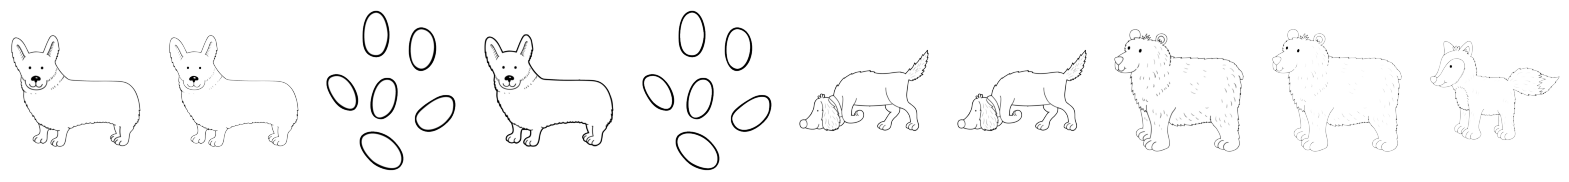

In [16]:
def query_model1(query: str, count: int = 10, draw = False):
    global cliparts
    global cliparts_txt
    hits = []

    result=cliparts.search(
        [text_model.encode(query)],
        anns_field="img_embeddings",
        limit=count,
        param={"metric_type": "COSINE", "params": {"nprobe": 2}},
        output_fields=["path", "text"],
    )

    result=result[0]

    if draw is False:
        for i,hit in enumerate(result):
            hits.append(hit.entity.get('text'))
    else:
        fig,ax=plt.subplots(1,count)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        for i,hit in enumerate(result):
            img=np.asarray(Image.open(hit.entity.get('path')))
            if img.shape[-1]<3:
                img=img[...,0]
            ax[i].imshow(img, cmap='gray')
            ax[i].set_axis_off()
            hits.append(hit.entity.get('text'))
    return hits  

hits = query_model1("hund", 10, True)   
print(hits)        

In [17]:
results_en_model1 = {}
results_de_model1 = {}

for query in tqdm(ground_truth_en.keys()):
    paths = ground_truth_en[query]
    count = len(paths)
    results = query_model1(query, count, False)
    results_en_model1[query] = results

for query in tqdm(ground_truth_de.keys()):
    paths = ground_truth_de[query]
    count = len(paths)
    results = query_model1(query, count, False)
    results_de_model1[query] = results    

results_model1 = {}
results_model1.update(results_de_model1)
results_model1.update(results_en_model1)

print(results_model1)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

{' stapel aus büchern': ['data Cliparts 01 Kate Hadfield SnowDay khadfield SnowDay snowballs png', 'data Cliparts 01 Kate Hadfield OnTheFarm OnTheFarmStamps LINE ART khadfield OnTheFarmStamps haybale png', 'data Cliparts 01 Kate Hadfield ToothFairy ToothFairyStamps LINE ART khadfield ToothFairyStamps toothbrush3 png', 'data Cliparts 01 Kate Hadfield ToothFairy ToothFairyStamps DIGITAL STAMPS khadfield ToothFairyStamps toothbrush3 2 png', 'data Cliparts 01 Kate Hadfield WalkInTheWoods WalkInTheWoodsStamps BOLD khadfield WalkInTheWoodsStamps BOLD acorn1 png', 'data Cliparts 01 Kate Hadfield WinterWishes WinterWishesStamps DIGITAL STAMPS khadfield WinterWishesStamps mittens 2 png', 'data Cliparts 01 Kate Hadfield WinterWishes WinterWishesStamps LINE ART khadfield WinterWishesStamps mittens png', 'data Cliparts 01 Kate Hadfield FruitStand FruitStandStamps BOLD khadfield FruitStandStamps BOLD watermelon png', 'data Cliparts 01 Kate Hadfield AtoZ Objects AtoZ ObjectsStamps DIGITAL STAMPS kha

### Model 2: CLIP+ResNet

In [ ]:
# inspired by https://huggingface.co/mlunar/clip-variants/blob/main/example.py

providers = ['CPUExecutionProvider']
visual = VisualModel("models/clip-resnet-101-visual-float32.onnx", providers=providers)

embeddings_total = [[]]

count = 0

# very hacky way to split the image paths into chunks, but otherwise the onnxruntime stops with an OutOfMem error 
# code for splitting a list into chunks from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

for x in tqdm(batch(img_paths, 1000), total = math.ceil(len(img_paths) / 1000)):
    images_input = visual.preprocess_images(x)
    image_embeddings = visual.encode(images_input)
    if count == 0:
        embeddings_total = image_embeddings
    else: 
        embeddings_total = np.concatenate((embeddings_total, image_embeddings), axis=0)
    count = count + 1

image_embeddings = embeddings_total    



In [ ]:
textual = TextualModel("models/clip-resnet-101-textual-float32.onnx", providers=providers)

embeddings_total = [[]]

count = 0

# same problem as above
# code for splitting a list into chunks from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

for x in tqdm(batch(imgs['text'], 1000), total = math.ceil(len(imgs['text']) / 1000)):
    texts_input = textual.tokenize(x)
    text_embeddings = textual.encode(texts_input)

    if count == 0:
        embeddings_total = text_embeddings
    else: 
        embeddings_total = np.concatenate((embeddings_total, text_embeddings), axis=0)
    count = count + 1

text_embeddings = embeddings_total    



In [ ]:
imgs["img_embeddings"] = image_embeddings.tolist()
imgs["txt_embeddings"] = text_embeddings.tolist()

imgs

In [ ]:
imgs.to_json('data/img_embedded_model2.json',orient='records')

In [18]:
imgs=pd.read_json('data/img_embedded_model2.json',orient='records')

In [19]:
drop_collections()
setup_collections()
create_indices()
insert_into_db()

  0%|          | 0/8209 [00:00<?, ?it/s]

['data Cliparts 01 Kate Hadfield SleepTight SleepTightStamps DIGITAL STAMPS khadfield SleepTightStamps cat 2 png', 'data Cliparts 01 Kate Hadfield SleepTight SleepTightStamps BOLD khadfield SleepTightStamps BOLD cat png', 'data Cliparts 01 Kate Hadfield FatCatOnAMat FatCatOnAMatStamps BOLD khadfield FatCatStampsEU BOLD fatcat2 png', 'data Cliparts 01 Kate Hadfield OnTheFarm khadfield OnTheFarm cat png', 'data Cliparts 01 Kate Hadfield FranknFriends FranknFriendsStamps DIGITAL STAMPS khadfield FrankNFriendsStamps blackcat 2 png', 'data Cliparts 01 Kate Hadfield FranknFriends FranknFriendsStamps BOLD khadfield FrankNFriendsStamps BOLD blackcat 2 png', 'data Cliparts 01 Kate Hadfield AtoZ khadfield AtoZ cat png', 'data Cliparts 01 Kate Hadfield FatCatOnAMat FatCatOnAMatStamps DIGITAL STAMPS khadfield FatCatStampsEU fatcat2 2 png', 'data Cliparts 01 Kate Hadfield WitchingHour WitchingHourStamps DIGITAL STAMPS khadfield WitchingHourStamps cat 2 png', 'data Cliparts 01 Kate Hadfield SafariMa

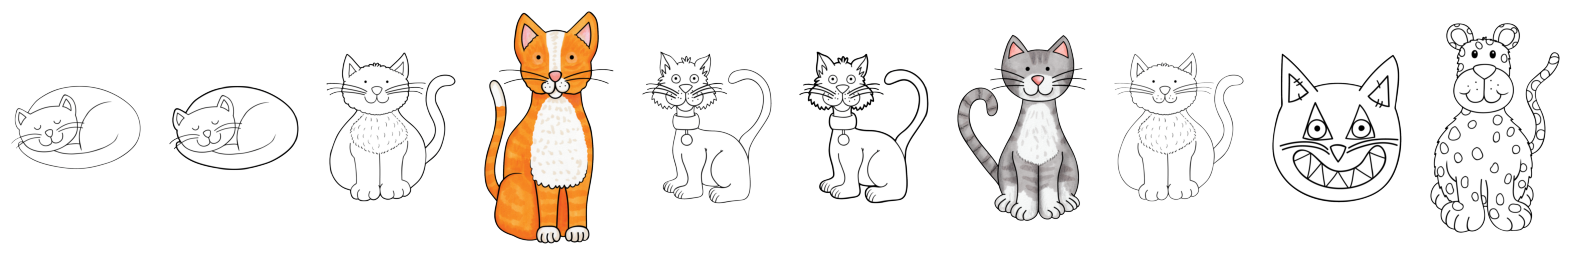

In [21]:
def query_model2(query: str, count: int = 10, draw = False):
    global cliparts
    global cliparts_txt
    hits = []

    query_embedding = textual.encode(textual.tokenize([query]))

    result=cliparts.search(
        query_embedding,
        anns_field="img_embeddings",
        limit=count,
        param={"metric_type": "COSINE", "params": {"nprobe": 2}},
        output_fields=["path", "text"],
    )

    result=result[0]

    if draw is False:
        for i,hit in enumerate(result):
            hits.append(hit.entity.get('text'))
    else:
        fig,ax=plt.subplots(1,count)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        for i,hit in enumerate(result):
            img=np.asarray(Image.open(hit.entity.get('path')))
            if img.shape[-1]<3:
                img=img[...,0]
            ax[i].imshow(img, cmap='gray')
            ax[i].set_axis_off()
            #print(hit.entity.get('text'))
            hits.append(hit.entity.get('text'))
    return hits

hits = query_model2("cat", 10, True)   
print(hits)  

In [22]:
results_en_model2 = {}
results_de_model2 = {}

for query in tqdm(ground_truth_en.keys()):
    paths = ground_truth_en[query]
    count = len(paths)
    results = query_model2(query, count, False)
    results_en_model2[query] = results

for query in tqdm(ground_truth_de.keys()):
    paths = ground_truth_de[query]
    count = len(paths)
    results = query_model2(query, count, False)
    results_de_model2[query] = results    

results_model2 = {}
results_model2.update(results_de_model2)
results_model2.update(results_en_model2)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Compare approaches

In [26]:
def check_models_with_ground_truth(ground_truth, model_results):
    precision_scores = []
        
    for query in tqdm(ground_truth.keys()):
        paths = ground_truth[query]

        if model_results[query] is not None:
            precision_score_value = precision_air(paths, model_results[query], 20)
            precision_scores.append(precision_score_value)
        else:
            print(f"No results for query ", query)

    average_precision_score = sum(precision_scores) / len(precision_scores)
    print(f'Average precision score: {average_precision_score}')


ground_truth = {}
ground_truth.update(ground_truth_de)
ground_truth.update(ground_truth_en)

print("Running German queries with model 1........")
check_models_with_ground_truth(ground_truth_de, results_de_model1)   
print("Running English queries with model 1........")
check_models_with_ground_truth(ground_truth_en, results_en_model1)
print("Running German queries with model 2........")
check_models_with_ground_truth(ground_truth_de, results_de_model2)   
print("Running English queries with model 2........")
check_models_with_ground_truth(ground_truth_en, results_en_model2)

Running German queries with model 1........


  0%|          | 0/36 [00:00<?, ?it/s]

Average precision score: 0.13256172839506172
Running English queries with model 1........


  0%|          | 0/36 [00:00<?, ?it/s]

Average precision score: 0.31603913062246397
Running German queries with model 2........


  0%|          | 0/36 [00:00<?, ?it/s]

Average precision score: 0.04259259259259259
Running English queries with model 2........


  0%|          | 0/36 [00:00<?, ?it/s]

Average precision score: 0.2870586203919537


In [27]:
def calculate_similarity_tfidf(query, k = 10):
    relevant_docs = []

    documents = imgs["text"].to_list()

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    query_tfidf = tfidf_vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
    document_ranks = sorted(enumerate(cosine_similarities), key=lambda x: x[1], reverse=True)[:k]

    for rank, score in document_ranks:
        # print(f"{documents[rank]}: Similarity Score = {score:.4f}")
        relevant_docs.append(documents[rank])

    return relevant_docs

relevant_docs = calculate_similarity_tfidf("ostern", 10)
print(relevant_docs)


['data Cliparts 01 Kate Hadfield logo cropped png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 chevron png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 circles1 png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 circles2 png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 leaves png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 scallop png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 scallops png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 small circles png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 stripes png', 'data Cliparts 01 Kate Hadfield 01 JoodleStrips JoodleStrips5 khadfield JoodleStrips5 triangles png']


In [28]:
# TF-IDF as baseline
precision_scores = []

for query in tqdm(ground_truth.keys()):
    paths = ground_truth[query]
    count = len(paths)

    tfidf_predictions = calculate_similarity_tfidf(query, count)
    precision_score_value = precision_air(paths, tfidf_predictions, 20)
    precision_scores.append(precision_score_value)

average_precision_score = sum(precision_scores) / len(precision_scores)
print(f'Average precision score (TF-IDF): {average_precision_score}')

  0%|          | 0/72 [00:00<?, ?it/s]

Average precision score (TF-IDF): 0.20734177088343753
